In [104]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, precision_score

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6



In [58]:
shuffled_folder = 'dataset/shuffled/'
shuffled_files = [shuffled_folder + file for file in os.listdir(shuffled_folder)]
random.shuffle(shuffled_files)

In [59]:
num_files = len(shuffled_files)
training_cut = round(0.4 * num_files)
cross_cut = round(0.7 * num_files)

In [60]:
training_files = shuffled_files[:training_cut]
cross_validation_files = shuffled_files[training_cut:cross_cut]
test_files = shuffled_files[cross_cut:]

In [10]:
def get_train_test_dfs(file):
    df = pd.read_parquet(file)
    df = df.fillna(0)
    X = df[[i for i in df.columns if not i == 'label']]
    y = df[['label']]
    return train_test_split(X, y, test_size=0.3, stratify=y)

In [72]:
X_train, X_test, y_train, y_test = get_train_test_dfs(training_files[8])

In [12]:
def check_distrib(df):
    df = df[['label']]
    ones = len(df[df['label'] == 1])
    return ones / len(df)

In [73]:
len(X_train), len(y_train), len(X_test), len(y_test)

(6587395, 6587395, 2823170, 2823170)

In [74]:
check_distrib(y_train), check_distrib(y_test)

(0.739918890547781, 0.7399189563504854)

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    conf_mat.plot()

---

In [118]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Flatten, Reshape, Dropout, Conv1D
from keras.regularizers import L1L2

In [134]:
model = Sequential()
model.add(Dense(units=50, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=200, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
# model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

In [135]:
model.fit(X_train, y_train)

205857/205857 [==============================] - 1329s 6ms/step - loss: 0.5440 - precision_9: 0.7402 - false_positives_9: 428465.3804 - true_negatives_9: 0.0000e+00


In [136]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.8505211735867056
Precision = 0.7399189563504854 



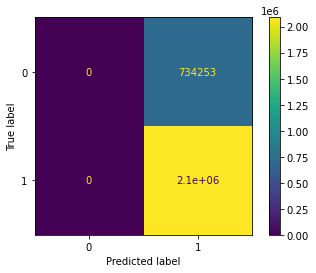

In [141]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [142]:
model = Sequential()
model.add(Dense(units=1, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

In [143]:
model.fit(X_train, y_train)

205857/205857 [==============================] - 1000s 5ms/step - loss: 0.5434 - precision_10: 0.7406 - false_positives_10: 427910.3043 - true_negatives_10: 123.5893


In [144]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.8506587435005278
Precision = 0.74014111430911 



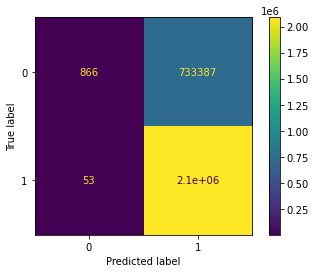

In [145]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)